## IMPORTS

In [6]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import bqplot as bqp
    from bqplot import pyplot as plt # bqplot is a plotting for jupyter
    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


## FILE SELECTION

In [7]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Experiment-A5')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                   
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        
        final_mol_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        #semifinal_mol_data =  [master_arr[i][-2][9:19]  for i in range(len(comp_names_arr))]
        
        df_end_flux_data = []
        
    
        for i in range(len(final_mol_data)):
            temp_arr =[]
            for j in range(len(final_mol_data[i])):
                final_mol_data[i][j] = final_mol_data[i][j] * master_arr[i][-1][3]
                #semifinal_mol_data[i][j] = semifinal_mol_data[i][j] * master_arr[i][-2][3]
                #temp_arr.append(final_mol_data[i][j]-semifinal_mol_data[i][j])
            #df_end_flux_data.append(temp_arr)
            
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2']
        df_end_flux = pd.DataFrame(data =final_mol_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]
       
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [((master_arr[i][-1][7] * master_arr[i][-1][3]) -(master_arr[i][-2][7] * master_arr[i][-2][3]))  for i in range(len(comp_names_arr))]
        #(master_arr[i][-2][7]- master_arr[i][-2][3]
        
        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Experiment-A5', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory


## 1) PARAMETER LINE GRAPHS

In [10]:
######### 
# GUI
drp_comp = widgets.Dropdown(description='Compartment:')


options_drp_comp = []
options_drp_comp.append('ALL COMPARTMENTS')

for i in range(len(comp_names_arr)):
    options_drp_comp.append(comp_names_arr[i])

drp_comp.options = options_drp_comp    


drp_param = widgets.Dropdown(description='Parameter:')
options_drp_param = ['Membrane Potential (Vm)','Cl- Reversal Potential (E-Cl)', 'K+ Reversal Potential (E-K)','Cl- Driving Force'
                        ,'Volume (pL)','',
                         'All ion concentrations','Na+ Conc.','K+ Conc.','Cl- Conc.','Impermeant anion Conc.']


drp_param.options = options_drp_param


sldr_start = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=5)


hbox_graph = widgets.HBox()
vbox_graph1 = widgets.VBox()
vbox_graph2 = widgets.VBox()
vbox_graph1.children =[drp_comp,drp_param]
vbox_graph2.children =[sldr_start]
hbox_graph.children = [vbox_graph1,vbox_graph2]

btn_main_graph = widgets.Button(description='Graph it!',button_style='success')
output10 = widgets.Output()
display(hbox_graph,btn_main_graph,output10)

number_of_colors = len(comp_names_arr)

color_arr = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


def plot_main_graph(param='',comp_num=0,all_comps =False,jump=1):
    
    
    start_t = sldr_start.value
      
        
    x_sc = bqp.LinearScale()
    y_sc = bqp.LinearScale()
    col_sc = bqp.ColorScale(scheme="RdYlGn")
    ax_x = bqp.Axis(scale = x_sc, label="Time(s)", min= start_t, max=t_arr[-1])
    ax_y = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='left')
    ax_y2 = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='right')
        
        
        
    if all_comps == True:
                      
        m_arr = []
        output10.clear_output()
                   
         
        
        for i in range(len(comp_names_arr)):
            col = color_arr[i]
            y_arr = []   
                #f1_title = "All Compartments"+" : " + "Time (s) vs " + drp_param.value 
                
            if param == 'Membrane Potential (Vm)':
                
                y_arr = [master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = [col], 
                    display_legend=True,labels= ['Vm - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Reversal Potential (E-Cl)':
                
                
                y_arr = [master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-Cl - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Reversal Potential (E-K)':
                
                y_arr = [master_arr[i][j][-2]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1], y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-K - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Driving Force':
                
                y_arr = [master_arr[i][j][-3]*1e3 - master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))] 
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
                
                
            elif param == 'Volume (pL)':
                
                y_arr = [master_arr[i][j][3]*1e12 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Vol. - '+comp_names_arr[i] ], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Na+ Conc.':
                
                y_arr = [master_arr[i][j][4]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Na+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Conc.':
                
                y_arr = [master_arr[i][j][5]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['K+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Conc.':
                
                y_arr = [master_arr[i][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['Cl- - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Impermeant anion Conc.':
                
                y_arr = [master_arr[i][j][7]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col], 
                       display_legend=True,labels= ['X -'+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))        
            
                
                
                       
                
        f1 = bqp.Figure(title ="", marks=m_arr, axes=[ax_x, ax_y],legend_location='top-right',scales={'x': x_sc, 'color': col_sc, 'y': y_sc})
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)
        
        
    if all_comps == False:            
            
            
        y_arr = []
            
        if param == 'Membrane Potential (Vm)':
                
            y_arr = [master_arr[comp_num][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Vm'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Reversal Potential (E-Cl)':
            
            y_arr = [master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bm1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-Cl'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Reversal Potential (E-K)':
                
            y_arr = [master_arr[comp_num][j][-2]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-K'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Driving Force':
             
            y_arr = [master_arr[comp_num][j][-3]*1e3 - master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]    
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[comp_num]], scales = {'x': x_sc, "y": y_sc})
                 
        elif param == 'Volume (pL)':
                
            y_arr = [master_arr[comp_num][j][3]*1e12 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'],
                       display_legend=True,labels= ['Vol.'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Na+ Conc.':
                
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Conc.':
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc}) 
             
        elif param == 'Cl- Conc.':
                
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc}) 
                
        elif param == 'Impermeant anion Conc.':
            
                   
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X Conc.'], scales = {'x': x_sc, "y": y_sc}) 
            
           
                
        elif param == 'All ion concentrations':
                
            m1 = []
            
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            a1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            a2 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                
            a3 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
                
            a4 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X'], scales = {'x': x_sc, "y": y_sc})
            
            
                
            m1 = [a1,a2,a3,a4]
                
                
                 
            f1 = bqp.Figure(title = comp_names_arr[comp_num] + ": all ion concentrations vs time", marks=m1, axes=[ax_x, ax_y],legend_location='top-right')
            f1.layout.height = '600px'
            f1.layout.width = '800px'
            output10.clear_output()
            with output10:    
                display(f1)
            return
            
    
    
        f1 = bqp.Figure(title = "", marks=[m1], axes=[ax_x, ax_y],legend_location='top-right')
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)

            
            
        
                
                
            

        #####


def btn_main_graph_clicked(b):
    
    
    start_t = int(sldr_start.value * 1000)

    

    
    
    
    
    if drp_comp.value == 'ALL COMPARTMENTS':
    
            param = drp_param.value
            plot_main_graph(param,all_comps=True)

    
    elif drp_comp.value != 'ALL COMPARTMENTS':
        
        
        for i in range(len(comp_names_arr)):
            if (drp_comp.value == comp_names_arr[i]):
                comp_num = i
              

        param = drp_param.value
        plot_main_graph(param,comp_num,all_comps=False)
         
        
btn_main_graph.on_click(btn_main_graph_clicked)

Button(button_style='success', description='Graph it!', style=ButtonStyle())

Output()

## 2) ION FLUXES

In [9]:
#############################################
# GUI SETUP

btn_ion_break = widgets.Button(description='View ion breakdown ', button_style='info')
drp_ion = widgets.Dropdown(options = ["Na","K","Cl"], description = "Ion")

output_ion_break = widgets.Output()


display(drp_ion,btn_ion_break, output_ion_break)

############################################


time_points = [round(t_arr[i*40],2) for i in range(25)]
time_points = time_points[1:]

def btn_ion_break_clicked(b):
    
    ion = drp_ion.value
    g1_data_arr, g2_data_arr,g3_data_arr, g4_data_arr,g5_data_arr = [], [],[],[],[]
    
    for i in range(1,len(comp_names_arr)):
    
        leak_arr = []
        atp_arr = []
        kcc2_arr =[]
        ed_arr = []
        nett_arr = []
        
        
        for j in range(len(time_points)):
            
            timepoint = (j+1)*40
            
            if ion == "Na":
                leak_arr.append(master_arr[i][timepoint][10] * master_arr[i][timepoint][3])
                atp_arr.append(master_arr[i][timepoint][11] * master_arr[i][timepoint][3])
                
                if i ==0: # if first compartment, only need 1 ED value
                    ed_value= -1*ED_master_arr[i][timepoint][0] * master_arr[i][timepoint][3]
                elif i == len(comp_names_arr)-1: # if last compartment, only need 1 ED value
                    ed_value = ED_master_arr[i-1][timepoint][0] * master_arr[i-1][timepoint][3]
                else:
                    ed_value = (ED_master_arr[i-1][timepoint][0] * master_arr[i-1][timepoint][3])
                    -(ED_master_arr[i][timepoint][0] * master_arr[i][timepoint][3] )
                ed_arr.append(ed_value)
                
                nett_arr.append(master_arr[i][timepoint][10]+master_arr[i][timepoint][11]+ed_value)
                
            elif ion == "K":
                leak_arr.append(master_arr[i][timepoint][13] * master_arr[i][timepoint][3])
                atp_arr.append(master_arr[i][timepoint][14] * master_arr[i][timepoint][3])
                kcc2_arr.append(master_arr[i][timepoint][15] * master_arr[i][timepoint][3])
                if i ==0:
                    ed_value = -1*ED_master_arr[i][timepoint][1] * master_arr[i][timepoint][3]
                elif i == len(comp_names_arr)-1:
                    ed_value = ED_master_arr[i-1][timepoint][1] * master_arr[i-1][timepoint][3]
                else:
                    ed_value = (ED_master_arr[i-1][timepoint][1] * master_arr[i-1][timepoint][3])
                    -(ED_master_arr[i][timepoint][1] * master_arr[i][timepoint][3])
                ed_arr.append(ed_value)
                nett_arr.append(master_arr[i][timepoint][13]+master_arr[i][timepoint][14]+master_arr[i][timepoint][15] + ed_value)                               
            
            elif ion =="Cl":
                leak_arr.append(master_arr[i][timepoint][17] * master_arr[i][timepoint][3])
                kcc2_arr.append(master_arr[i][timepoint][18] * master_arr[i][timepoint][3])
                if i ==0:
                    ed_value=-1*ED_master_arr[i][timepoint][2] * master_arr[i][timepoint][3]
                elif i == len(comp_names_arr)-1:
                    ed_value = ED_master_arr[i-1][timepoint][2] * master_arr[i-1][timepoint][3]
                else:
                    ed_value = (ED_master_arr[i-1][timepoint][2] * master_arr[i-1][timepoint][3])
                    - (ED_master_arr[i][timepoint][2] * master_arr[i][timepoint][3])
                ed_arr.append(ed_value)
                
                nett_arr.append(master_arr[i][timepoint][17] + master_arr[i][timepoint][18] + ed_value)
        
        g1_data_arr.append(leak_arr)
        g2_data_arr.append(atp_arr)
        g3_data_arr.append(kcc2_arr)
        g4_data_arr.append(ed_arr)
        g5_data_arr.append(nett_arr)
        
    
         #Creating figure
    with output_ion_break:

        output_ion_break.clear_output()
        sns.set(font_scale=2)
        if ion =="Na":
            fig_ionbreak, (ax1,ax2,ax3,ax4) = mplt.subplots(4,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, center=np.mean(g1_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("Na_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)

            g2 = sns.heatmap(g2_data_arr, center=np.mean(g2_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax2)
            g2.set_xticklabels(time_points, fontsize=20)
            g2.set_ylabel("Na_ATPase",fontsize=40)
            g2.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g4 = sns.heatmap(g4_data_arr, center=np.mean(g4_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax3)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("Na_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g5 = sns.heatmap(g5_data_arr, center=np.mean(g5_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax4)
            g5.set_xticklabels(time_points, fontsize=20)
            g5.set_ylabel("Na_Nett",fontsize=40)
            g5.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)

                #g3 = sns.heatmap(cl_data, center=0, cmap="vlag", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
                #g3.set_xticklabels(time_points, fontsize=20)
                #g3.set_yticklabels(comp_names_arr, fontsize=20)
                #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
                #fig_ionsource.suptitle("Na+ fluxes", fontsize=12)
                
        if ion =="K": 
            fig_ionbreak, (ax1,ax2,ax3,ax4,ax5) = mplt.subplots(5,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, center=np.mean(g1_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("K_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)

            g2 = sns.heatmap(g2_data_arr, center=np.mean(g2_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax2)
            g2.set_xticklabels(time_points, fontsize=20)
            g2.set_ylabel("K_ATPase",fontsize=40)
            g2.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g3 = sns.heatmap(g3_data_arr, center=np.mean(g3_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax3)
            g3.set_xticklabels(time_points, fontsize=20)
            g3.set_ylabel("K_KCC2",fontsize=40)
            g3.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g4 = sns.heatmap(g4_data_arr, center=np.mean(g4_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax4)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("K_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g5 = sns.heatmap(g5_data_arr, center=np.mean(g5_data_arr), cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax5)
            g5.set_xticklabels(time_points, fontsize=20)
            g5.set_ylabel("K_Nett",fontsize=40)
            g5.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
                
        if ion =="Cl":
            fig_ionbreak, (ax1,ax2,ax3,ax4) = mplt.subplots(4,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("Cl_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)

            g3 = sns.heatmap(g3_data_arr, cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax2)
            g3.set_xticklabels(time_points, fontsize=20)
            g3.set_ylabel("Cl_KCC2",fontsize=40)
            g3.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g4 = sns.heatmap(g4_data_arr, cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax3)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("Cl_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
            
            g5 = sns.heatmap(g5_data_arr, cmap="rocket_r", linewidth=2,cbar_kws={'label':'Moles'}, cbar=True,ax=ax4)
            g5.set_xticklabels(time_points, fontsize=20)
            g5.set_ylabel("Cl_Nett",fontsize=40)
            g5.set_yticklabels(comp_names_arr[1:], fontsize=20, rotation=0)
                
        fig_ionbreak.tight_layout()

        mplt.show()
        
btn_ion_break.on_click(btn_ion_break_clicked)

Dropdown(description='Ion', options=('Na', 'K', 'Cl'), value='Na')

Button(button_style='info', description='View ion breakdown ', style=ButtonStyle())

Output()

##  3) ELECTRODIFFUSION

Button(button_style='info', description='plot ED changes ', style=ButtonStyle())

Output()

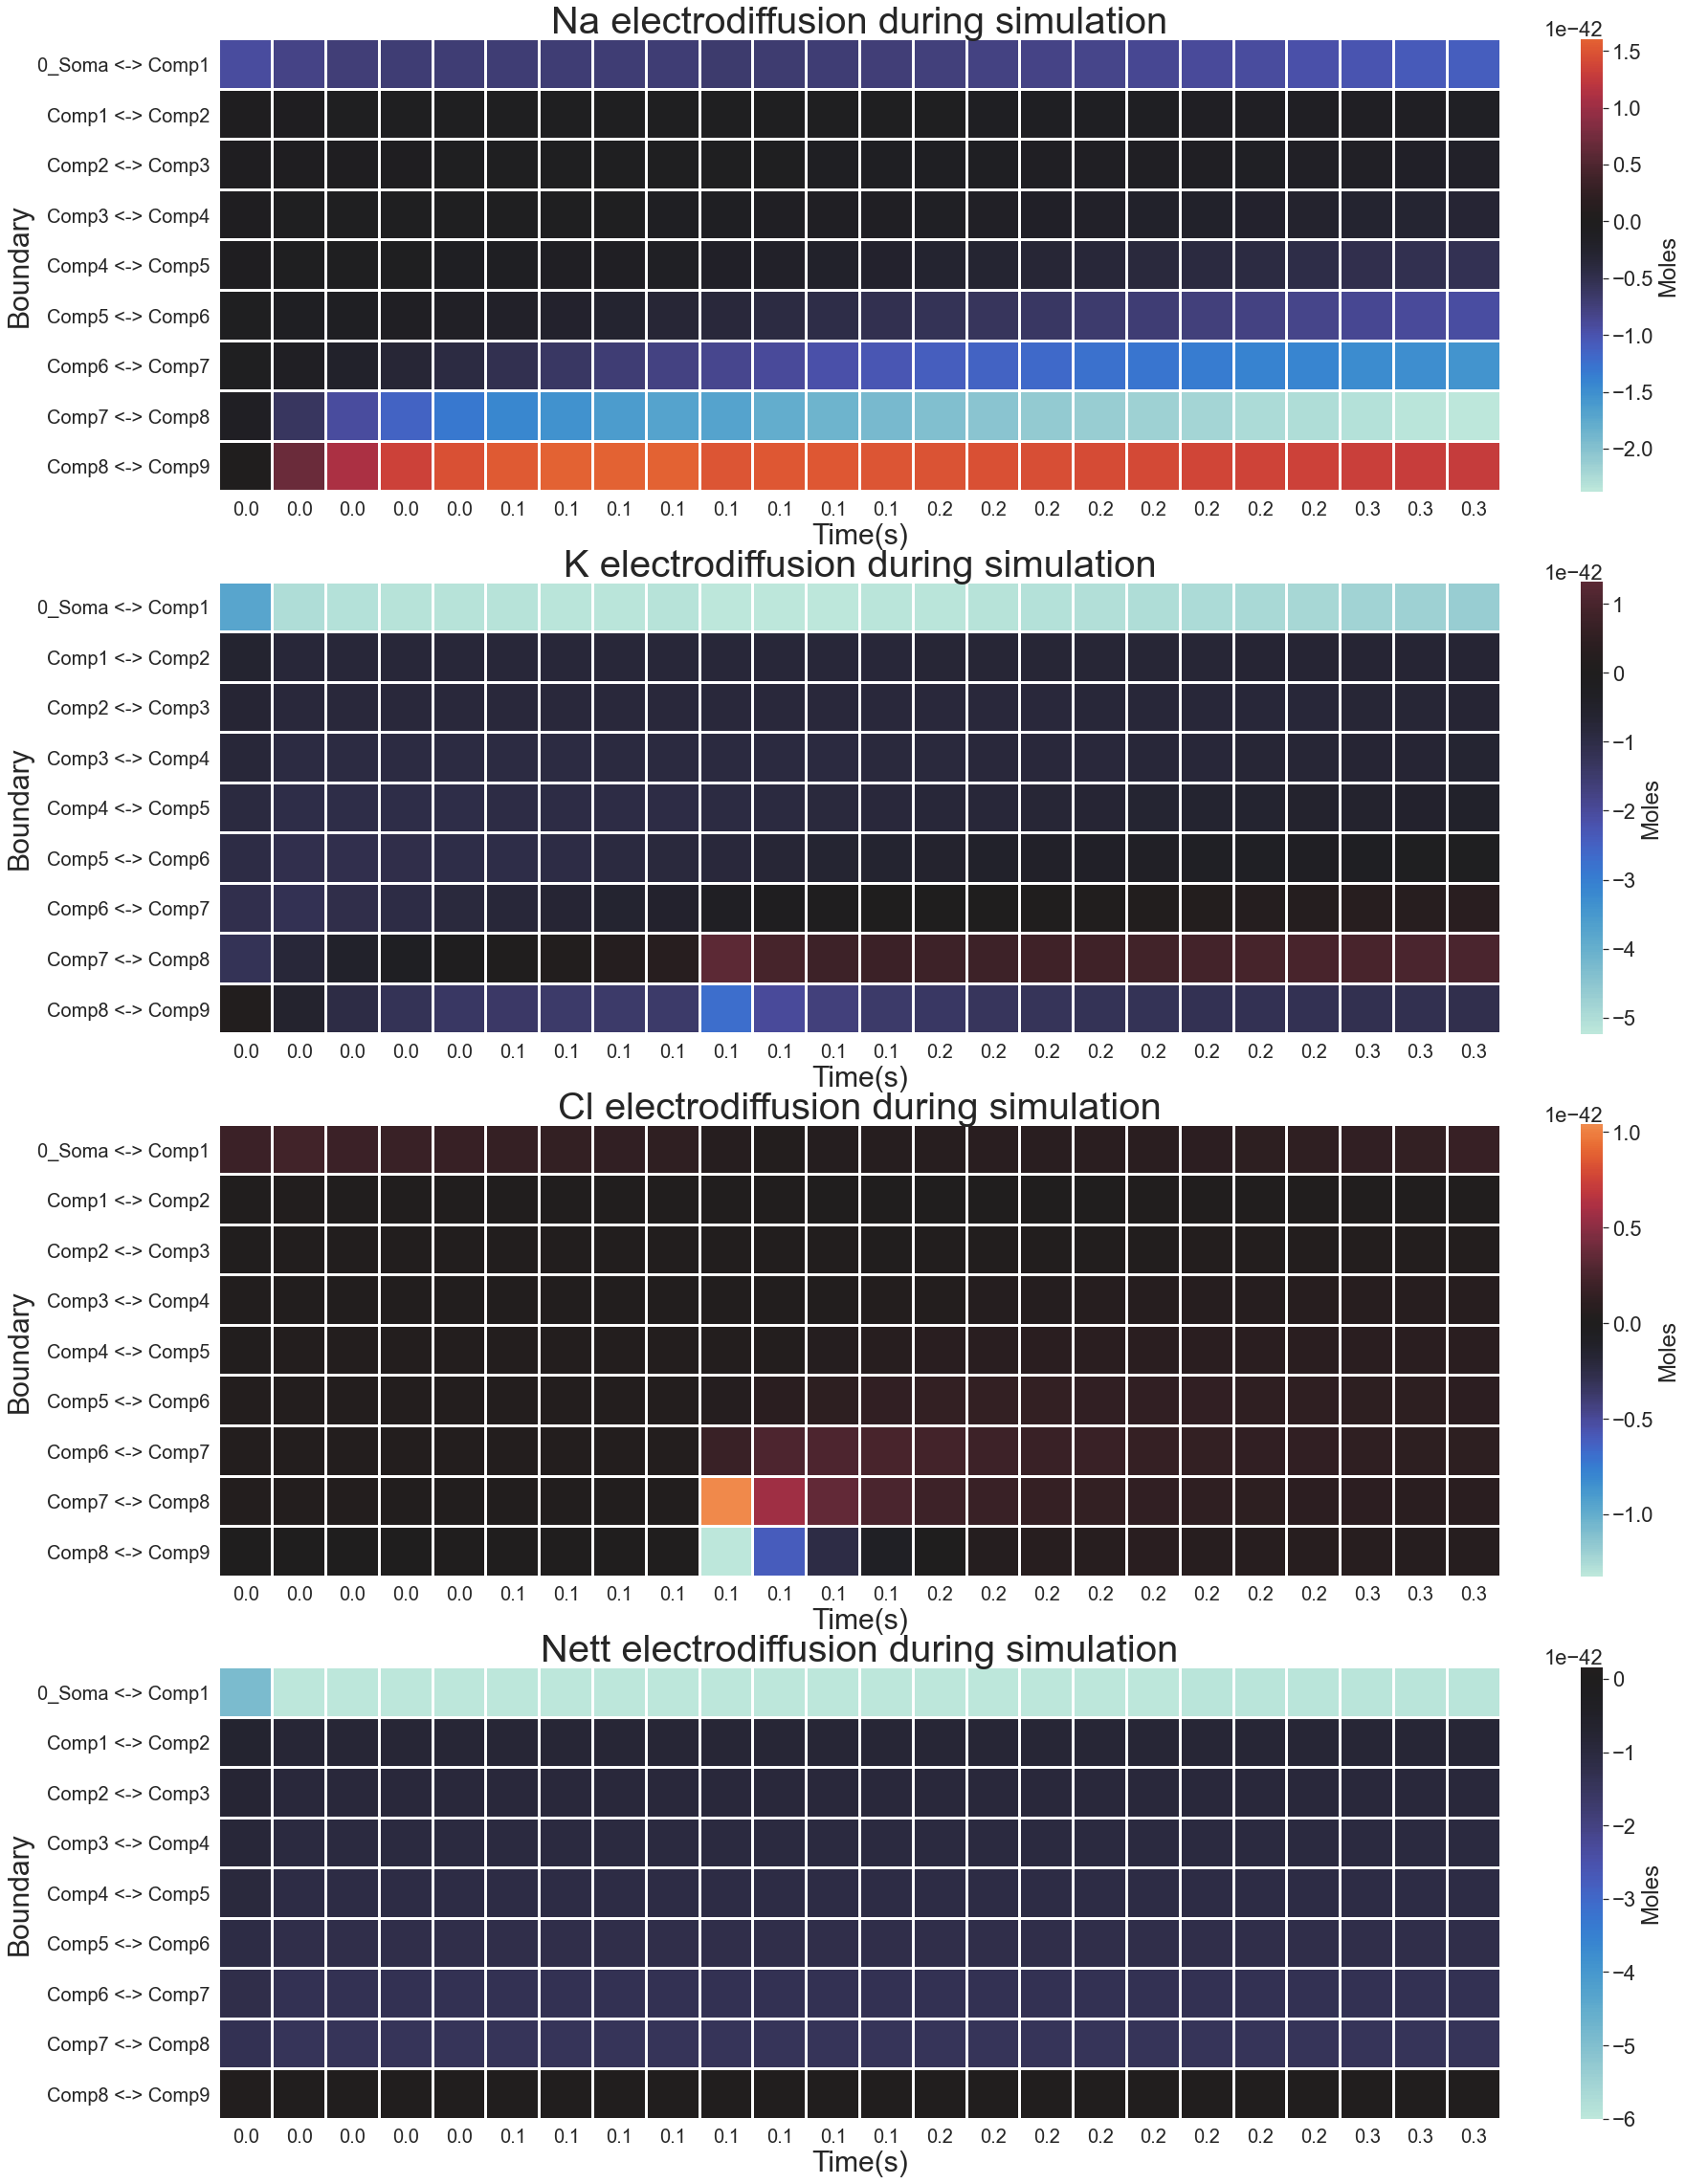

In [25]:
########
# Function to calculate all the axial voltages during the simulation
global na_ed_arr, k_ed_arr, cl_ed_arr, nett_ed_arr
na_ed_arr, k_ed_arr, cl_ed_arr, nett_ed_arr = [],[],[], []

global t_points_arr,x_ax_labels
num_bins = 25
#t_bins = round(len(interval_arr)/num_bins)
t_bins = round(len(master_arr[0])/num_bins)
t_points_arr = [i*t_bins for i in range(num_bins) ]
x_ax_labels = [round(t_arr[i*t_bins],1) for i in range(num_bins-1)]

    
for i in range(len(comp_names_arr)-1):
        
    temp_arr_1, temp_arr_2, temp_arr_3, temp_arr_4 = [],[],[],[]
    
    for t in range(len(t_points_arr)-1):
            
        timepoint = t_points_arr[t]
            
        na_ed = ED_master_arr[i][timepoint][0] * master_arr[i][timepoint][3]
        temp_arr_1.append(na_ed)
            
        k_ed = ED_master_arr[i][timepoint][1] * master_arr[i][timepoint][3]
        temp_arr_2.append(k_ed)
            
        cl_ed = ED_master_arr[i][timepoint][2] * master_arr[i][timepoint][3]
        temp_arr_3.append(cl_ed)
        
        nett_ed = na_ed + k_ed - cl_ed
        temp_arr_4.append(nett_ed)
        
    na_ed_arr.append(temp_arr_1)
    k_ed_arr.append(temp_arr_2)
    cl_ed_arr.append(temp_arr_3)
    nett_ed_arr.append(temp_arr_4)
        



#######################################
# GUI

btn_ed = widgets.Button(description='plot ED changes ', button_style='info')
output_ed = widgets.Output()
display(btn_ed, output_ed)

######################################
bound_names_arr = [comp_names_arr[i] + ' <-> ' + comp_names_arr[i+1] for i in range(len(comp_names_arr)-1)]


def btn_ed_clicked(b):
    
    f_ed, (ax_na_ed, ax_k_ed, ax_cl_ed, ax_nett_ed) = mplt.subplots(4 , 1 , figsize=( 30 , 40 ))
    #vmin=-1e-42,
    
    g_na_ed = sns.heatmap(na_ed_arr,cmap="icefire", center=0 ,linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax_na_ed)
    g_na_ed.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_na_ed.set_xticklabels(x_ax_labels, fontsize=20)
    g_na_ed.set_title("Na electrodiffusion during simulation", fontsize=40)
    g_na_ed.set_xlabel("Time(s)", fontsize=30)
    g_na_ed.set_ylabel("Boundary", fontsize=30)
 
    g_k_ed = sns.heatmap(k_ed_arr,cmap="icefire", center=0, linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax_k_ed)
    g_k_ed.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_k_ed.set_xticklabels(x_ax_labels, fontsize=20)
    g_k_ed.set_title("K electrodiffusion during simulation", fontsize=40)
    g_k_ed.set_xlabel("Time(s)", fontsize=30)
    g_k_ed.set_ylabel("Boundary", fontsize=30)
    
    g_cl_ed = sns.heatmap(cl_ed_arr,cmap="icefire", center=0, linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax_cl_ed)
    g_cl_ed.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_cl_ed.set_xticklabels(x_ax_labels, fontsize=20)
    g_cl_ed.set_title("Cl electrodiffusion during simulation", fontsize=40)
    g_cl_ed.set_xlabel("Time(s)", fontsize=30)
    g_cl_ed.set_ylabel("Boundary", fontsize=30)
    
    g_nett_ed = sns.heatmap(nett_ed_arr,cmap="icefire", center=0, linewidth=2,cbar_kws={'label':'Moles'},cbar=True,ax=ax_nett_ed)
    g_nett_ed.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_nett_ed.set_xticklabels(x_ax_labels, fontsize=20)
    g_nett_ed.set_title("Nett electrodiffusion during simulation", fontsize=40)
    g_nett_ed.set_xlabel("Time(s)", fontsize=30)
    g_nett_ed.set_ylabel("Boundary", fontsize=30)
                   
    
    
    mplt.show()
    

######################################
btn_ed.on_click(btn_ed_clicked)

## 4) TRANSMEMBRANE POTENTIALS


In [26]:

############################################
# GUI SETUP

btn_memb_voltages = widgets.Button(description='Compare voltages', button_style='info')
output_memb_voltages = widgets.Output()
display(btn_memb_voltages, output_memb_voltages)

############################################

def btn_memb_voltages_clicked(b):
   

    v_memb_arr, e_cl_memb_arr, df_cl_memb_arr =[],[],[]
    
    num_bins = 25
    #t_bins = round(len(interval_arr)/num_bins)
    t_bins = round(len(master_arr[0])/num_bins)
    t_points_arr = [i*t_bins for i in range(num_bins) ]
    x_ax_labels = [round(t_arr[i*t_bins],1) for i in range(num_bins)]
    x_ax_labels = x_ax_labels[1:]
    
    #Heatmap data
    for i in range(len(comp_names_arr)):
        
        temp_arr_1, temp_arr_2, temp_arr_3 = [],[],[]
    
        for t in range(len(t_points_arr)-1):
            
            time_point = t_points_arr[t+1]
            v_memb = master_arr[i][time_point][-3] 
            temp_arr_1.append(v_memb*1e3)
            e_cl_memb = master_arr[i][time_point][-1] 
            temp_arr_2.append(e_cl_memb*1e3)
            df_cl_memb = v_memb - e_cl_memb
            temp_arr_3.append(df_cl_memb*1e3)
        
        v_memb_arr.append(temp_arr_1)
        e_cl_memb_arr.append(temp_arr_2)
        df_cl_memb_arr.append(temp_arr_3)
        
    
    
   
    
    #Creating figure
    with output_memb_voltages:
        
        output_memb_voltages.clear_output()
        
        
        f_memb_voltages, (ax_v_memb, ax_e_cl_memb, ax_df_cl_memb) = mplt.subplots(3 , 1 , figsize=( 30 , 40 ))

    
        g_v_memb= sns.heatmap(v_memb_arr,cmap="icefire", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_v_memb)
        g_v_memb.set_yticklabels(comp_names_arr, fontsize=20, rotation=0)
        g_v_memb.set_xticklabels(x_ax_labels, fontsize=20)
        g_v_memb.set_title("Membrane voltages during simulation", fontsize=40)
        g_v_memb.set_xlabel("Time(s)", fontsize=30)
        g_v_memb.set_ylabel("Compartment", fontsize=30)
 
        g_e_cl_memb = sns.heatmap(e_cl_memb_arr,cmap="icefire",  linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_e_cl_memb)
        g_e_cl_memb.set_yticklabels(comp_names_arr, fontsize=20, rotation=0)
        g_e_cl_memb.set_xticklabels(x_ax_labels, fontsize=20)
        g_e_cl_memb.set_title("Membrane E-Cl during simulation", fontsize=40)
        g_e_cl_memb.set_xlabel("Time(s)", fontsize=30)
        g_e_cl_memb.set_ylabel("Compartment", fontsize=30)
        
        #center =10.5,
        g_df_cl_memb = sns.heatmap(df_cl_memb_arr,cmap="icefire",   linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_df_cl_memb)
        g_df_cl_memb.set_yticklabels(comp_names_arr, fontsize=20, rotation=0)
        g_df_cl_memb.set_xticklabels(x_ax_labels, fontsize=20)
        g_df_cl_memb.set_title("Membrane Cl driving force during simulation", fontsize=40)
        g_df_cl_memb.set_xlabel("Time(s)", fontsize=30)
        g_df_cl_memb.set_ylabel("Compartment", fontsize=30)

    
    
        mplt.show()
    
    
    
    
btn_memb_voltages.on_click(btn_memb_voltages_clicked)



Button(button_style='info', description='Compare voltages', style=ButtonStyle())

Output()

## 5) BOUNDARY POTENTIALS

Button(button_style='info', description='plot axial voltages ', style=ButtonStyle())

Output()

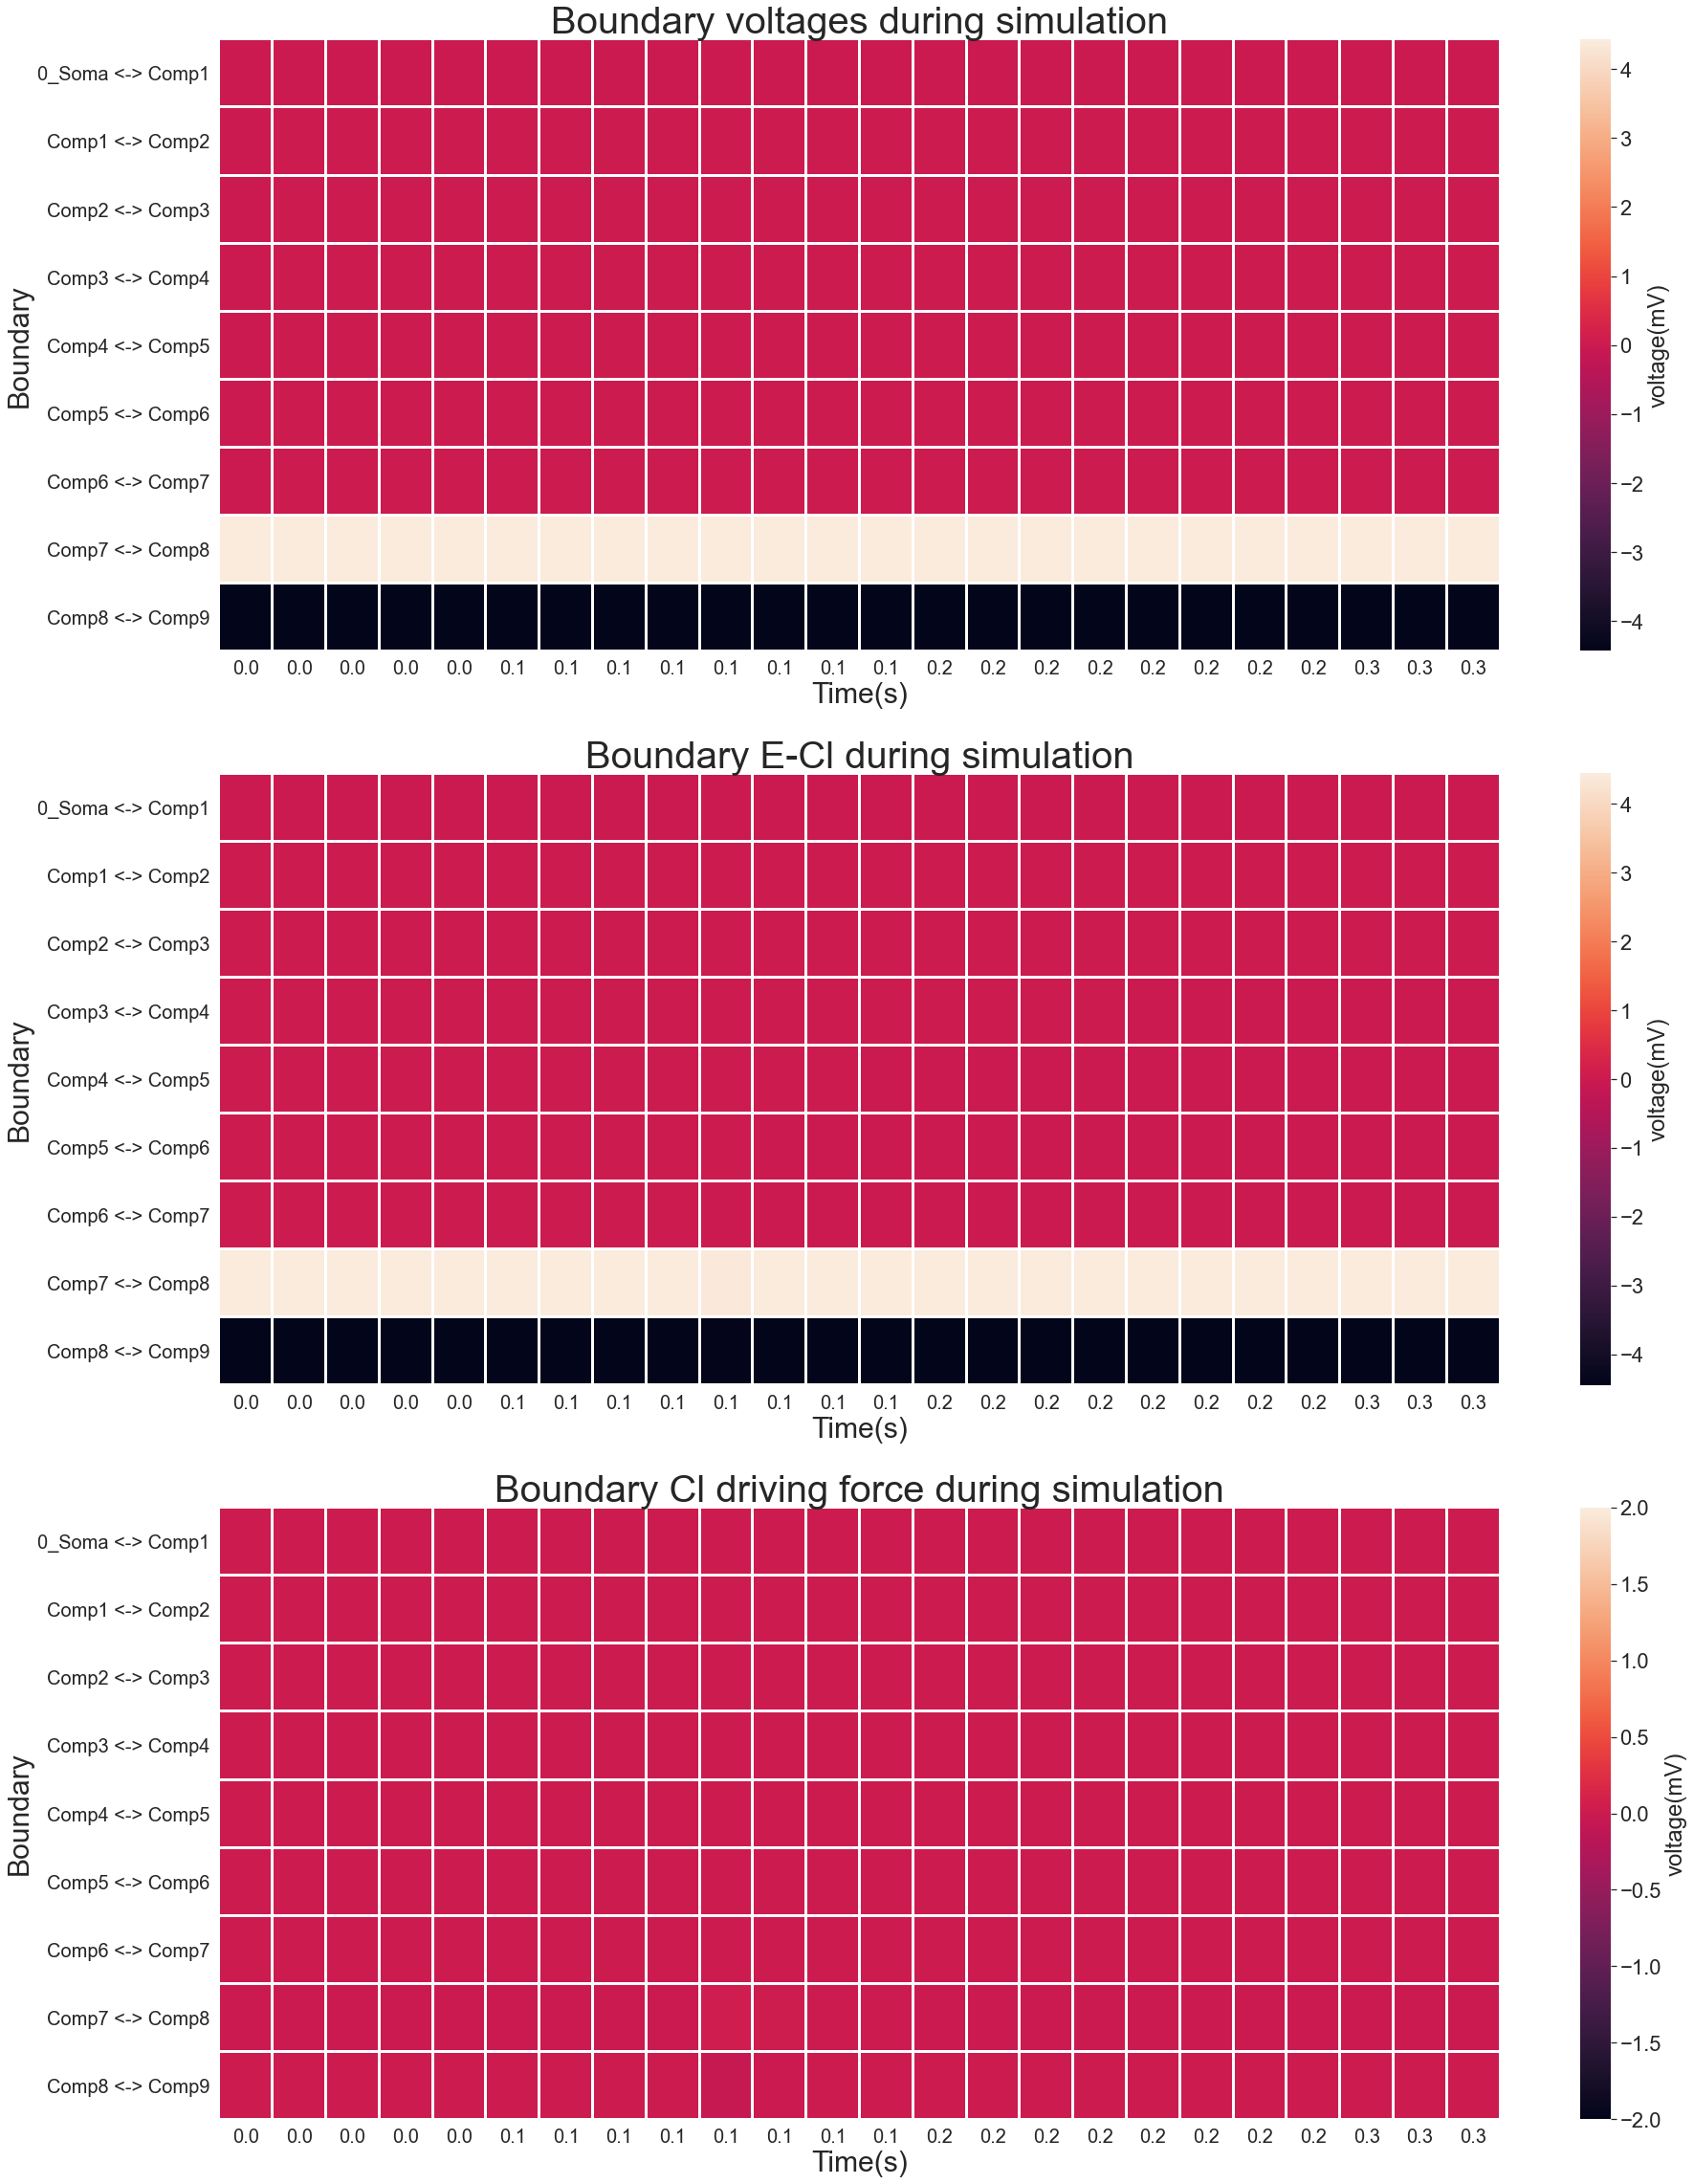

In [27]:
########
# Function to calculate all the axial voltages during the simulation
global v_bound_arr, e_cl_bound_arr, df_cl_bound_arr
v_bound_arr, e_cl_bound_arr, df_cl_bound_arr = [],[],[]
global RTF
R = 8.31446
F = 96485.33  # Faraday's constant        C mol-1
T = 37 + 273.15
RTF = R * T / F

global t_points_arr,x_ax_labels
num_bins = 25
#t_bins = round(len(interval_arr)/num_bins)
t_bins = round(len(master_arr[0])/num_bins)
t_points_arr = [i*t_bins for i in range(num_bins) ]
x_ax_labels = [round(t_arr[i*t_bins],1) for i in range(num_bins-1)]


def calc_axial_voltages():
     
    
    for i in range(len(comp_names_arr)-1):
        
        temp_arr_1, temp_arr_2, temp_arr_3 = [],[],[]
    
        for t in range(len(t_points_arr)-1):
            
            time_point = t_points_arr[t]
            

            v_bound = master_arr[i][time_point][-3] - master_arr[i+1][time_point][-3]
            temp_arr_1.append(v_bound*1e3)
            
            e_cl_bound = RTF * np.log(master_arr[i][time_point][6] / master_arr[i+1][time_point][6])
            temp_arr_2.append(e_cl_bound*1e3)
            
            df_cl_bound = v_bound - e_cl_bound
            temp_arr_3.append(df_cl_bound*1e3)
        
        v_bound_arr.append(temp_arr_1)
        e_cl_bound_arr.append(temp_arr_2)
        df_cl_bound_arr.append(temp_arr_3)
        
    return 

calc_axial_voltages()

#######################################
# GUI

btn_axial_voltages = widgets.Button(description='plot axial voltages ', button_style='info')
output_axial_voltages = widgets.Output()
display(btn_axial_voltages, output_axial_voltages)

######################################
bound_names_arr = [comp_names_arr[i] + ' <-> ' + comp_names_arr[i+1] for i in range(len(comp_names_arr)-1)]


def btn_axial_voltages_clicked(b):
    
    f_axial_voltages, (ax_v_bound, ax_e_cl_bound, ax_df_cl_bound) = mplt.subplots(3 , 1 , figsize=( 30 , 40 ))

    
    g_v_bound = sns.heatmap(v_bound_arr,cmap="rocket", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_v_bound)
    g_v_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_v_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_v_bound.set_title("Boundary voltages during simulation", fontsize=40)
    g_v_bound.set_xlabel("Time(s)", fontsize=30)
    g_v_bound.set_ylabel("Boundary", fontsize=30)
 
    g_e_cl_bound = sns.heatmap(e_cl_bound_arr,cmap="rocket", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_e_cl_bound)
    g_e_cl_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_e_cl_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_e_cl_bound.set_title("Boundary E-Cl during simulation", fontsize=40)
    g_e_cl_bound.set_xlabel("Time(s)", fontsize=30)
    g_e_cl_bound.set_ylabel("Boundary", fontsize=30)
    
    g_df_cl_bound = sns.heatmap(df_cl_bound_arr,cmap="rocket", vmax=2, vmin=-2, linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_df_cl_bound)
    g_df_cl_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_df_cl_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_df_cl_bound.set_title("Boundary Cl driving force during simulation", fontsize=40)
    g_df_cl_bound.set_xlabel("Time(s)", fontsize=30)
    g_df_cl_bound.set_ylabel("Boundary", fontsize=30)
                   
    
    
    mplt.show()
    

######################################
btn_axial_voltages.on_click(btn_axial_voltages_clicked)